In [40]:
using DelimitedFiles
using PyCall
using PyPlot
using Random
using Setfield
using Statistics
using ProgressMeter
using JLD2
using HDF5
using FileIO
using DataStructures
using CUDA
using DrWatson
using Measurements: value, uncertainty, ±

using Revise

using CMBLensing
using PtsrcLens

# Parallel setup

In [4]:
using Distributed, ClusterManagers
cluster_cookie("marius")
em = ElasticManager(addr=:auto, port=9312);

In [5]:
em

ElasticManager:
  Active workers : []
  Number of workers to be added  : 0
  Terminated workers : []
  Worker connect command : 
    /global/home/users/mariusmillea/src/julia-1.5.2/bin/julia --project=/global/home/users/mariusmillea/work/ptsrclens/Project.toml -e 'using ClusterManagers; ClusterManagers.elastic_worker("marius          ","10.0.0.24",9312)'

In [7]:
@everywhere using CUDA, CMBLensing, PtsrcLens

In [8]:
CMBLensing.assign_GPU_workers();

In [9]:
for i in workers()
    @fetchfrom i println(gethostname(),"::",device())
end

      From worker 2:	n0018.savio2::CuDevice(0)
      From worker 3:	n0018.savio2::CuDevice(1)
      From worker 4:	n0018.savio2::CuDevice(2)
      From worker 5:	n0018.savio2::CuDevice(3)
      From worker 6:	n0019.savio2::CuDevice(0)
      From worker 7:	n0019.savio2::CuDevice(3)
      From worker 8:	n0019.savio2::CuDevice(1)
      From worker 9:	n0019.savio2::CuDevice(2)
      From worker 10:	n0023.savio2::CuDevice(0)
      From worker 11:	n0023.savio2::CuDevice(1)
      From worker 12:	n0023.savio2::CuDevice(2)
      From worker 13:	n0023.savio2::CuDevice(3)
      From worker 14:	n0024.savio2::CuDevice(0)
      From worker 15:	n0024.savio2::CuDevice(1)
      From worker 16:	n0024.savio2::CuDevice(2)
      From worker 17:	n0024.savio2::CuDevice(3)


# Load files

In [52]:
@unpack (ϕs, κs, gs_ir, gs_radio, Ms_radio) = load_hdf5_cutouts();

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:03:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 

In [53]:
@save "data/sehgal_maps_h5/cutouts.jld2" ϕs κs gs_ir gs_radio Ms_radio;

## Load pre-processed

In [7]:
@load "data/sehgal_maps_h5/cutouts.jld2"

5-element Array{Symbol,1}:
 :ϕs
 :κs
 :gs_ir
 :gs_radio
 :Ms_radio

# Check power

In [25]:
@unpack (fg_noise_radio, fg_noise_ir) = get_foreground_noise(;Ms_radio, gs_radio, gs_ir);

In [42]:
tab = pyimport("pandas").DataFrame(Dict(
    148 => OrderedDict(fluxcut => value(fg_noise_radio[:deep,148,fluxcut]) for fluxcut in [Inf,10,5,2]),
    90  => OrderedDict(fluxcut => value(fg_noise_radio[:wide,90, fluxcut]) for fluxcut in [Inf,10,5,2]),
)).T
println(tab.to_latex(float_format="%.2f"))
tab

\begin{tabular}{lrrrr}
\toprule
{} &  inf  &  10.0 &  5.0  &  2.0  \\
\midrule
148 &  0.63 &  0.08 &  0.06 &  0.03 \\
90  &  1.46 &  0.19 &  0.13 &  0.08 \\
\bottomrule
\end{tabular}



,inf,10.0,5.0,2.0
148,0.632798,0.080185,0.057939,0.034663
90,1.464721,0.185232,0.131259,0.075241


In [43]:
fg_noise_ir

Dict{Tuple{Symbol,Int64,Float64},Float64} with 2 entries:
  (:deep, 148, Inf) => 0.0740397
  (:wide, 148, Inf) => 0.0740397

In [44]:
fg_noise_radio

OrderedDict{Tuple{Symbol,Int64,Real},Measurement{Float64}} with 16 entries:
  (:deep, 90, 2)    => 0.074±0.039
  (:deep, 90, 5)    => 0.13±0.022
  (:deep, 90, 10)   => 0.184±0.016
  (:deep, 90, Inf)  => 1.4647±0.0034
  (:deep, 148, 2)   => 0.035±0.034
  (:deep, 148, 5)   => 0.058±0.02
  (:deep, 148, 10)  => 0.08±0.015
  (:deep, 148, Inf) => 0.6328±0.0023
  (:wide, 90, 2)    => 0.08±0.12
  (:wide, 90, 5)    => 0.131±0.071
  (:wide, 90, 10)   => 0.185±0.05
  (:wide, 90, Inf)  => 1.4647±0.0067
  (:wide, 148, 2)   => 0.036±0.052
  (:wide, 148, 5)   => 0.06±0.031
  (:wide, 148, 10)  => 0.082±0.023
  (:wide, 148, Inf) => 0.6328±0.003

# Reconstruct

In [37]:
ℓedges = [2:100:500; round.(Int, 10 .^ range(log10(502), log10(6000), length=10))];

In [38]:
noises = Dict(
    (:deep, 90)  => (μKarcminT=0.68/√2, beamFWHM=2.3, ℓknee=200, αknee=2),
    (:wide, 90)  => (μKarcminT=2.9/√2,  beamFWHM=2.2, ℓknee=700, αknee=1.4),
    (:deep, 148) => (μKarcminT=0.96/√2, beamFWHM=1.5, ℓknee=200, αknee=2),
    (:wide, 148) => (μKarcminT=2.8/√2,  beamFWHM=1.4, ℓknee=700, αknee=1.4),
);

In [39]:
ℓmax_datas = [3000, 5000]
polfrac_scales = [1]
freqs = [90, 148]
surveys = [:deep, :wide];

In [ ]:
# PtsrcLens.main_MAP_grid(;surveys,freqs,ℓmax_datas,fluxcuts=[5],polfrac_scales=[1])

In [ ]:
PtsrcLens.main_MAP_grid(;surveys=[:deep],freqs=[90],ℓmax_datas=[3000],fluxcuts=[5],polfrac_scales=[1],Nbatch=1,overwrite=true,sims=1:32);

Progress: 100%|█████████████████████████████████████████| Time: 0:09:37


# Convergence

In [4]:
Cℓ = get_fiducial_Cℓ(ϕs);

In [22]:
ℓmax_data = 3000
polfrac_scale = 1
freq = 90
survey = :deep
fluxcut = 10;

In [23]:
noise_kwargs = noises[survey,freq]

(μKarcminT = 0.48083261120685233, beamFWHM = 2.3, ℓknee = 200, αknee = 2)

In [67]:
@unpack ds = load_sim_dataset(;
    Cℓ = Cℓ,
    θpix = 2,
    Nside = 300,
    pol = :P,
    bandpass_mask = LowPass(ℓmax_data),
    Nbatch = 1,
    noise_kwargs...
);

@unpack B = ds
ds.Cϕ = Cℓ_to_Cov(ϕs[1], (Cℓ.total.ϕϕ, ℓedges, :Aϕ));

μKarcmin_g = μKarcmin_gs_radio[survey,freq,fluxcut]

Cℓg = noiseCℓs(μKarcminT=polfrac_scale*μKarcmin_g/√2, beamFWHM=0, ℓknee=0)
Cg = Cℓ_to_Cov(Flat(Nside=300, θpix=2), Float32, S2, Cℓg.EE, Cℓg.BB);

let M = Ms_radio[survey,freq,fluxcut][1], g = gs_radio[freq][1]
    ds.Cn += polfrac_scale^2*B*Cg*B'
end;

In [77]:
resimulate!(ds, seed=0)
@everywhere ds=$ds;

fJ,ϕJ,g = @fetch begin
    ds′=cu(ds)
    fJ,ϕJ = MAP_joint(
        ds′,
        Nϕ       = :qe,
        nsteps   = 30,
        progress = false,
    )[1:2]
    g = gradient(Aϕ -> lnP(0,fJ,ϕJ,(Aϕ=Aϕ,),ds′), ones(Float32,length(ℓedges)-1))[1]
    (f=cpu(fJ), ϕ=cpu(ϕJ), g=g)
end;

In [79]:
let M = Ms_radio[survey,freq,fluxcut][1], g = gs_radio[freq][1]
    resimulate!(ds, seed=0)
    ds.d  += polfrac_scale*B*M*g
end;
@everywhere ds=$ds;

fJ′,ϕJ′,g′ = @fetch begin
    ds′=cu(ds)
    fJ,ϕJ = MAP_joint(
        ds′,
        Nϕ       = :qe,
        nsteps   = 30,
        progress = false,
    )[1:2]
    g = gradient(Aϕ -> lnP(0,fJ,ϕJ,(Aϕ=Aϕ,),ds′), ones(Float32,length(ℓedges)-1))[1]
    (f=cpu(fJ), ϕ=cpu(ϕJ), g=g)
end;

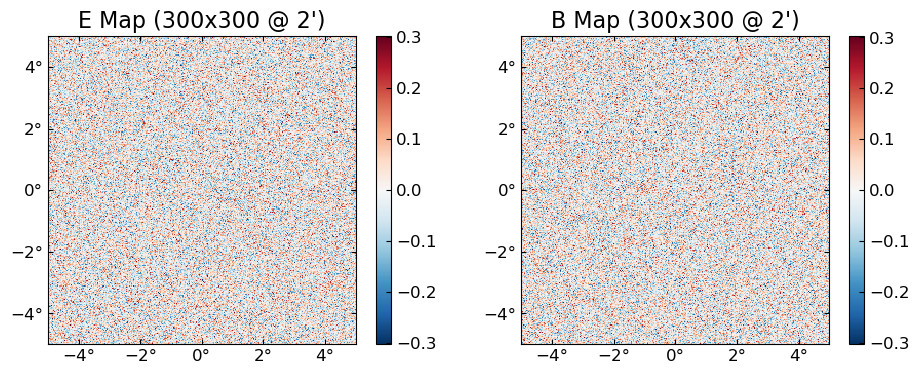

In [88]:
plot(simulate(Cg))

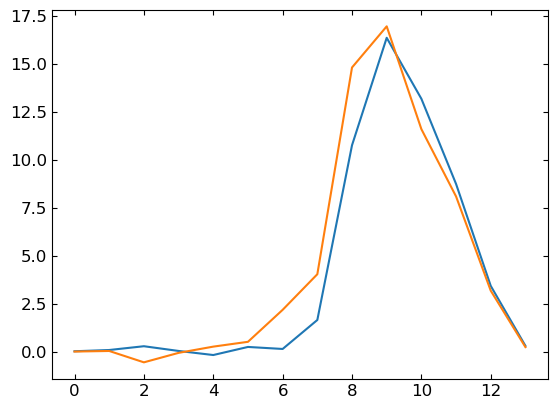

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x2afb517acd50>

In [85]:
plot(g′ - g)
plot(g″ - g)

In [82]:
[g g′ g″]

14×3 Array{Float32,2}:
     -0.678138      -0.658793      -0.674635
      4.07963        4.16412        4.11361
     -2.31098       -2.02946       -2.86899
    -15.652        -15.6167       -15.7164
     -0.447472      -0.624649      -0.186874
    -10.7515       -10.5076       -10.2399
    -70.4195       -70.2805       -68.2419
   -206.955       -205.306       -202.922
   -575.743       -564.99        -560.938
  -1534.35       -1518.0        -1517.4
  -3173.24       -3160.07       -3161.65
  -5909.18       -5900.44       -5901.09
 -10566.7       -10563.3       -10563.5
 -15237.0       -15236.7       -15236.7

In [80]:
let M = Ms_radio[survey,freq,fluxcut][1], g = gs_radio[freq][1]
    resimulate!(ds, seed=0)
    ds.d += polfrac_scale*B*M*simulate(Cg,seed=0)
end;
@everywhere ds=$ds;

fJ″,ϕJ″,g″ = @fetch begin
    ds′=cu(ds)
    fJ,ϕJ = MAP_joint(
        ds′,
        Nϕ       = :qe,
        nsteps   = 30,
        progress = false,
    )[1:2]
    g = gradient(Aϕ -> lnP(0,fJ,ϕJ,(Aϕ=Aϕ,),ds′), ones(Float32,length(ℓedges)-1))[1]
    (f=cpu(fJ), ϕ=cpu(ϕJ), g=g)
end;

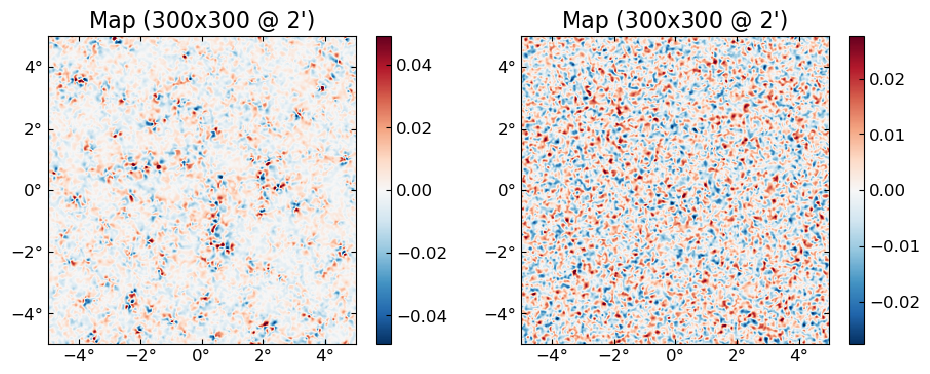

In [73]:
plot([∇²*(ϕJ′-ϕJ) ∇²*(ϕJ″-ϕJ)])

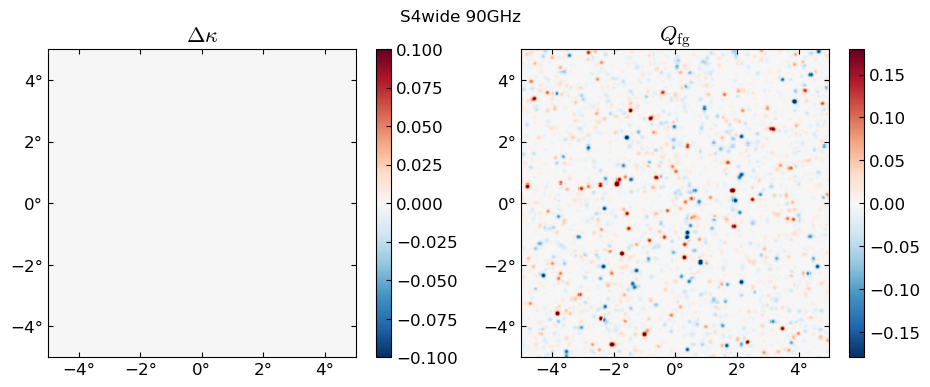

PyObject Text(0.5, 0.98, 'S4wide 90GHz')

In [64]:
plot(
    [∇²*(ϕJ′-ϕJ) (BandPassOp(beamCℓs(beamFWHM=5))*Ms_radio[survey,freq,fluxcut][1]*gs_radio[freq][1])[:Q]],
    title=[L"\Delta \kappa" L"Q_{\rm fg}"]
)
suptitle("S4wide 90GHz")

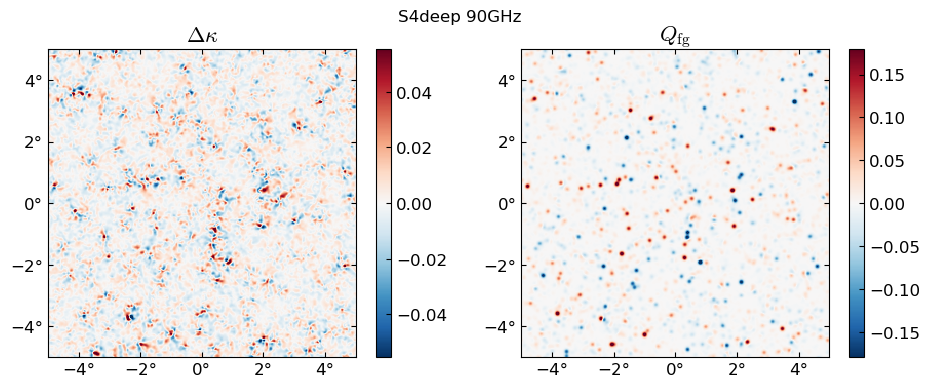

PyObject Text(0.5, 0.98, 'S4deep 90GHz')

In [35]:
plot(
    [∇²*(ϕJ′-ϕJ) (BandPassOp(beamCℓs(beamFWHM=5))*Ms_radio[survey,freq,fluxcut][1]*gs_radio[freq][1])[:Q]],
    title=[L"\Delta \kappa" L"Q_{\rm fg}"]
)
suptitle("S4deep 90GHz")